In [1]:
using PyPlot
using MotionPlanning
using ImmutableArrays
using ProfileView
include(Pkg.dir("MotionPlanning")*"/test/obstaclesets/2D.jl")
include(Pkg.dir("MotionPlanning")*"/test/obstaclesets/ND.jl")

INFO: Loading help data...


In [53]:
include("discreteLQG.jl")
include("collisionprobability.jl")
include("printhelpers.jl")

show (generic function with 143 methods)

In [54]:
function ISRR_test_problems(setup = :SI2)
    function double_integrator_noise(d)
        srand(1)
        V0 = rand(d,d) |> x-> x'*x 
        V1 = rand(d,d) |> x-> x'*x 
        W0 = rand(d,d) |> x-> x'*x 
        W1 = rand(d,d) |> x-> x'*x 
        pos_v = .05^2
        vel_v = .05^2
        Vc = [pos_v*V0 zeros(d,d); zeros(d,d) vel_v*V1]
        # V = diagm([pos_v^2*ones(d), vel_v^2*ones(d)])
        pos_w = .01^2
        vel_w = .005^2
        # W = diagm([pos_w^2*ones(d), vel_w^2*ones(d)])
        Wc = [pos_w*W0 zeros(d,d); zeros(d,d) vel_w*W1]
        P0 = diagm([pos_v^2*ones(d), vel_v^2*ones(d)])

        Vc, Wc, P0
    end
    
    if setup == :SI2
        P = MPProblem(UnitHypercube(2),
                      Vector2(.1,.1),
                      PointGoal([.9, .9]),
                      PointRobot2D(ISRR_POLY))
        DLQG = SingleIntegrator(2, nsf=0.3, dt=.03)
    elseif setup == :DI2
        P = MPProblem(DoubleIntegrator(2, vmax = 0.5),
                      [.1, .1, 0., 0.],
                      PointGoal([.9, .9, 0., 0.]),
                      PointRobot2D(ISRR_POLY))
        DLQG = DiscreteLQG(P.SS, double_integrator_noise(2)..., nsf=0.5, dt = .1)
    elseif setup == :SI3
        P = MPProblem(UnitHypercube(3),
                      [.1,.1,.1],
                      PointGoal([.9,.5,.1]),
                      PointRobotNDBoxes(BOXES3D))
        DLQG = SingleIntegrator(3, nsf=0.3, dt=.03)
    elseif setup == :DI3
        P = MPProblem(DoubleIntegrator(3, vmax = 0.5),
                      [.1,.1,.1,0.,0.,0.],
                      PointGoal([.9,.5,.1,0.,0.,0.]),
                      PointRobotNDBoxes(BOXES3D))
        DLQG = DiscreteLQG(P.SS, double_integrator_noise(3)..., nsf=0.5, dt = .1)
    end
    P, DLQG
end

ISRR_test_problems (generic function with 2 methods)

In [55]:
function quick_test(setup, eps)
    P, DLQG = ISRR_test_problems(setup)
    fmtstar!(P, 2000, connections = :R, rm = 1.5)
    collision_probability_stats(P, eps, DLQG, 2000, vis=true)
end

function run_tests(setup, CPgoal, M=20, N=20)
    P, DLQG = ISRR_test_problems(setup)
    DLQG = SingleIntegrator(2, nsf=0.4, dt=.03);
    plan_cache_times = Float64[]
    results = {}

    for m in 1:M
        println("======== Sample Set $(m) ========")
        P.V = defaultNN(P.SS, P.init)
        tic()
        fmtstar!(P, 2000, connections = :R, rm = 1.5)
        push!(plan_cache_times, toq())
        println("Planner Cache Time: $(plan_cache_times[end])")

        for n in 1:N
            push!(results, binary_search_CP(P, CPgoal, DLQG, 500, lo = 0., hi = .05, verbose = false))
        end
    end
    
    plan_cache_times, results
end

run_tests (generic function with 3 methods)

Planning Time 0.049357456
1.0e-5
1.0000000000000002e-6
1000
2000
Naive MC: 1.065199861
1000
2000
Variance Reduction: 1.619381438


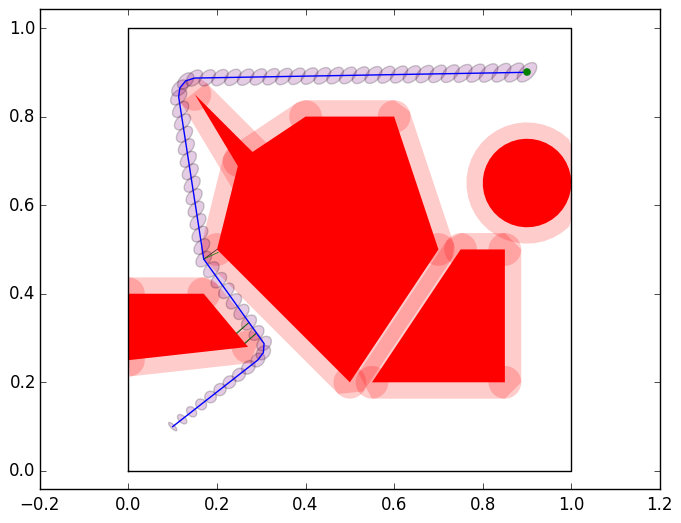

Dict{Any,Any} with 11 entries:
  "f"                => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.…
  "ISh"              => [0.0,9.594875259783311e-6,0.0,0.0,9.084099446045862e-6,…
  "IS_paths"         => (Array{T,1},Any)[([[0.1121546327155081,0.09426521200390…
  "h"                => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.…
  "P0"               => MPProblem(Euclidean() Metric Space,[0.1,0.1],PointGoal{…
  "path"             => Path of length 62
  "theta"            => 1.2153588682687512e-5
  "particle_paths"   => Array{T,1}[[[0.10642449634644686,0.09722145644156957],[…
  "ISf"              => [0.0001468183819691174,4.7974376298916555e-6,0.0,0.0,4.…
  "prunedCPestimate" => 1.4263928065583187e-5
  "alpha"            => [4.657195981826556e-6,1.8659134142465636e-6,5.630479286…

In [56]:
quick_test(:SI2, 0.037)

In [15]:
run_tests(:SI2, 0.01, 1, 1)
run_tests(:DI2, 0.01, 1, 1)
run_tests(:SI3, 0.01, 1, 1)
run_tests(:DI3, 0.01, 1, 1)

======== Sample Set 1 ========
Planner Cache Time: 0.050817472


LoadError: Initial bisection interval doesn't contain CPgoal: (0.014151789966065696,0.01,0.781632831481523)
while loading In[15], in expression starting on line 1

In [9]:
# PCTs, results = run_tests(:SI2, 0.01, 1, 1)

======== Sample Set 1 ========
Planner Cache Time: 1.002423283


LoadError: Initial bisection interval doesn't contain CPgoal: (0.043572480328170335,0.01,0.8126416345101966)
while loading In[9], in expression starting on line 1